## Add Embedding layers to Language Modules

In [1]:
import numpy as np
import torch

from torch import nn

from src.lmc.modules.lm import GRUDecoder, OneHotEncoder, init_rnn_params
from src.lmc.modules.obs import ObservationEncoder


class GRUEncoder(nn.Module):
    """
    Class for a language encoder using a Gated Recurrent Unit network
    """
    def __init__(self, context_dim, hidden_dim, embed_dim, word_encoder, 
                 n_layers=1, device='cpu', do_embed=True):
        """
        Inputs:
            :param context_dim (int): Dimension of the context vectors (output
                of the model).
            :param hidden_dim (int): Dimension of the hidden state of the GRU
                newtork.
            :param word_encoder (OneHotEncoder): Word encoder, associating 
                tokens with one-hot encodings
            :param n_layers (int): number of layers in the GRU (default: 1)
            :param device (str): CUDA device
        """
        super(GRUEncoder, self).__init__()
        self.device = device
        self.word_encoder = word_encoder
        self.context_dim = context_dim
        self.hidden_dim = hidden_dim
        self.do_embed = do_embed
        
        self.embed_layer = nn.Embedding(self.word_encoder.enc_dim, embed_dim)
        
        if not self.do_embed:
            embed_dim = self.word_encoder.enc_dim
            
        self.gru = nn.GRU(
            embed_dim, 
            self.hidden_dim, 
            n_layers,
            batch_first=True)
        init_rnn_params(self.gru)
        
        self.out = nn.Linear(self.hidden_dim, context_dim)
        self.norm = nn.LayerNorm(context_dim)
        
    def embed_sentences(self, sent_batch):
        # Get one-hot encodings
        enc_sent_batch = self.word_encoder.encode_batch(sent_batch)
        
        # Embed
        if self.do_embed:
            enc_ids_batch = [s.argmax(-1) for s in enc_sent_batch]
            return [self.embed_layer(s) for s in enc_ids_batch]
        else:
            return enc_sent_batch

    def forward(self, sent_batch):
        """
        Transforms sentences into embeddings
        Inputs:
            :param sentence_batch (list(list(str))): Batch of sentences.
        Outputs:
            :param unsorted_hstates (torch.Tensor): Final hidden states
                corresponding to each given sentence, dim=(1, batch_size, 
                context_dim)
        """
        # Get one-hot encodings
        enc_sent_batch = self.word_encoder.encode_batch(sent_batch)

        # Get order of sententes sorted by length decreasing
        ids = sorted(
            range(len(enc_sent_batch)), 
            key=lambda x: len(enc_sent_batch[x]), 
            reverse=True)

        # Sort the sentences by length
        sorted_list = [enc_sent_batch[i] for i in ids]

        # Embed
        if self.do_embed:
            enc_ids_batch = [s.argmax(-1) for s in sorted_list]
            model_input = [self.embed_layer(s) for s in enc_ids_batch]
        else:
            model_input = sorted_list

        # Pad sentences
        padded = nn.utils.rnn.pad_sequence(
            model_input, batch_first=True)

        # Pack padded sentences (to not care about padded tokens)
        lens = [len(s) for s in sorted_list]
        packed = nn.utils.rnn.pack_padded_sequence(
            padded, lens, batch_first=True).to(self.device)

        # Initial hidden state
        hidden = torch.zeros(1, len(enc_sent_batch), self.hidden_dim, 
                        device=self.device)
        
        # Pass sentences into GRU model
        _, hidden_states = self.gru(packed, hidden)

        # Re-order hidden states
        unsorted_hstates = torch.zeros_like(hidden_states).to(self.device)
        unsorted_hstates[0,ids,:] = hidden_states[0,:,:]

        return self.norm(self.out(unsorted_hstates))

    def get_params(self):
        return {'gru': self.gru.state_dict(),
                'out': self.out.state_dict()}

## Train

In [2]:
import json
import time
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch import nn, optim

import matplotlib.pyplot as plt

def load_pairs(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    pairs = []
    for step, s_data in data.items():
        if not step.startswith("Step"):
            continue
        pairs.append({
            "observation": s_data["Agent_0"]["Observation"],
            "sentence": s_data["Agent_0"]["Sentence"][1:-1]
        })
        pairs.append({
            "observation": s_data["Agent_1"]["Observation"],
            "sentence": s_data["Agent_1"]["Sentence"][1:-1]
        })
    return pairs

def init_training_objects(voc, context_dim, obs_dim, embed_dim, lr, do_embed=True):
    word_encoder = OneHotEncoder(voc)

    lang_enc = GRUEncoder(context_dim, 32, embed_dim, word_encoder, do_embed=do_embed)
    dec = GRUDecoder(context_dim, word_encoder)

    obs_enc = ObservationEncoder(obs_dim, context_dim)

    cross_ent_l = nn.CrossEntropyLoss()
    nll_l = nn.NLLLoss()
    opt = optim.Adam(list(lang_enc.parameters()) + list(dec.parameters()) + list(obs_enc.parameters()), lr=lr)
    
    return word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt

def sample_batch(data, batch_size):
    batch = random.sample(data, batch_size)
    obs_batch = []
    sent_batch = []
    for pair in batch:
        obs_batch.append(pair["observation"])
        sent_batch.append(pair["sentence"])
    return obs_batch, sent_batch

def get_losses(obs_batch, sent_batch, obs_enc, lang_enc, dec, temp, cross_ent_loss, nll_loss, obs_learn_capt):
    # Encode observations
    obs_tensor = torch.Tensor(np.array(obs_batch))
    context_batch = obs_enc(obs_tensor)

    # Encode sentence
    lang_context_batch = lang_enc(sent_batch)
    lang_context_batch = lang_context_batch.squeeze()

    # Compute similarity
    norm_context_batch = context_batch / context_batch.norm(dim=1, keepdim=True)
    lang_context_batch = lang_context_batch / lang_context_batch.norm(dim=1, keepdim=True)
    sim = norm_context_batch @ lang_context_batch.t() * temp
    mean_sim = sim.diag().mean()

    # Compute loss
    labels = torch.arange(len(obs_batch))
    loss_o = cross_ent_loss(sim, labels)
    loss_l = cross_ent_loss(sim.t(), labels)
    clip_loss = (loss_o + loss_l) / 2
    
    # Decoding
    encoded_targets = word_encoder.encode_batch(sent_batch)
    if not obs_learn_capt:
        context_batch = context_batch.detach()
    decoder_outputs, _ = dec(context_batch, encoded_targets)

    # Compute loss
    dec_loss = 0
    for d_o, e_t in zip(decoder_outputs, encoded_targets):
        e_t = torch.argmax(e_t, dim=1)
        dec_loss += nll_loss(d_o[:e_t.size(0)], e_t)
    
    return clip_loss, dec_loss, mean_sim

def train(data, obs_enc, lang_enc, dec, word_encoder, cross_ent_loss, nll_loss, opt, 
          n_iters=80000, batch_size=128, temp=0.07, eval_data=None, eval_evry=1000,
          sample_fn=sample_batch, clip_weight=1.0, capt_weight=1.0, obs_learn_capt=False):
    start = time.time()
    
    clip_train_losses = []
    clip_eval_losses = []
    dec_train_losses = []
    dec_eval_losses = []
    eval_sims = []
    
    for s_i in tqdm(range(n_iters)):
        opt.zero_grad()
        
        # Sample batch
        obs_batch, sent_batch = sample_fn(data, batch_size)
        
        # Compute both losses
        clip_loss, dec_loss, _ = get_losses(obs_batch, sent_batch, obs_enc, lang_enc, dec, temp, 
                                         cross_ent_loss, nll_loss, obs_learn_capt)
        
        # Backprop
        tot_loss = clip_weight * clip_loss + capt_weight * dec_loss
        tot_loss.backward()
        opt.step()
        
        clip_train_losses.append(clip_loss.item())
        dec_train_losses.append(dec_loss.item() / batch_size)
        
        if eval_data is not None and (s_i + 1) % eval_evry == 0:
            with torch.no_grad():
                # Sample batch
                obs_batch, sent_batch = sample_fn(eval_data, batch_size)
                
                # Get both losses
                clip_loss, dec_loss, sim = get_losses(
                    obs_batch, sent_batch, obs_enc, lang_enc, dec, temp, cross_ent_loss, nll_loss, obs_learn_capt)
                clip_eval_losses.append(clip_loss.item())
                dec_eval_losses.append(dec_loss.item() / batch_size)
                eval_sims.append(sim)
    
    return clip_train_losses, clip_eval_losses, dec_train_losses, dec_eval_losses, eval_sims

def plot_curves(curves, titles):
    """
    Inputs:
        curves (list(list(list(float)))): list of list of training curves, each element i of the main list is a list
            of all the training curves to plot in the subplot i.
    """
    nb_subplots = len(curves)
    
    fig, axs = plt.subplots(1, nb_subplots, figsize=(15,6))
    if type(axs) is not np.ndarray:
        axs = [axs]
    for ax, plot, title in zip(axs, curves, titles):
        max_len = max([len(c) for c in plot])
        for c in plot:
            c_len = len(c)
            if c_len == max_len:
                ax.plot(c)
            else:
                inter = max_len / c_len
                ax.plot((np.arange(c_len) + 1) * inter, c)
        ax.set_title(title)

In [3]:
data_pairs = load_pairs("../MALNovelD/test_data/Sentences_Generated_P1.json")

train_data = data_pairs[:80000]
test_data = data_pairs[80000:]

In [52]:
b = sample_batch(train_data, 2)
s = b[1]
s

[['Located', 'South', 'East', 'Object', 'North', 'East'],
 ['Located', 'North', 'West']]

100%|███████████████████████████████████████| 2000/2000 [02:10<00:00, 15.34it/s]


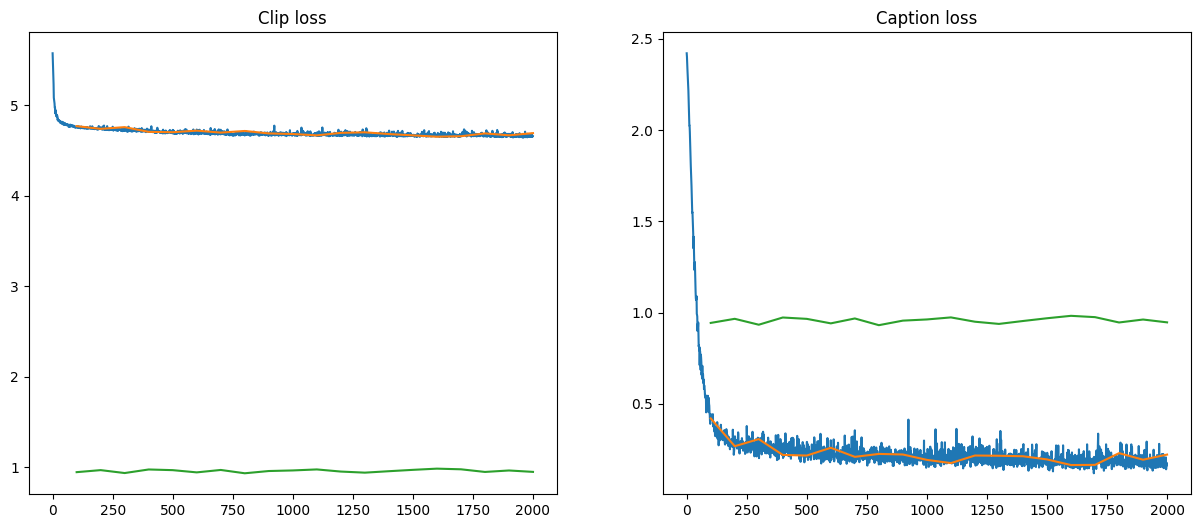

In [82]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    16, 17, 4, 0.007)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=256,
    eval_data=test_data, temp=1.0, n_iters=2000, eval_evry=100)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

No embedding layer

100%|███████████████████████████████████████| 2000/2000 [01:40<00:00, 19.92it/s]


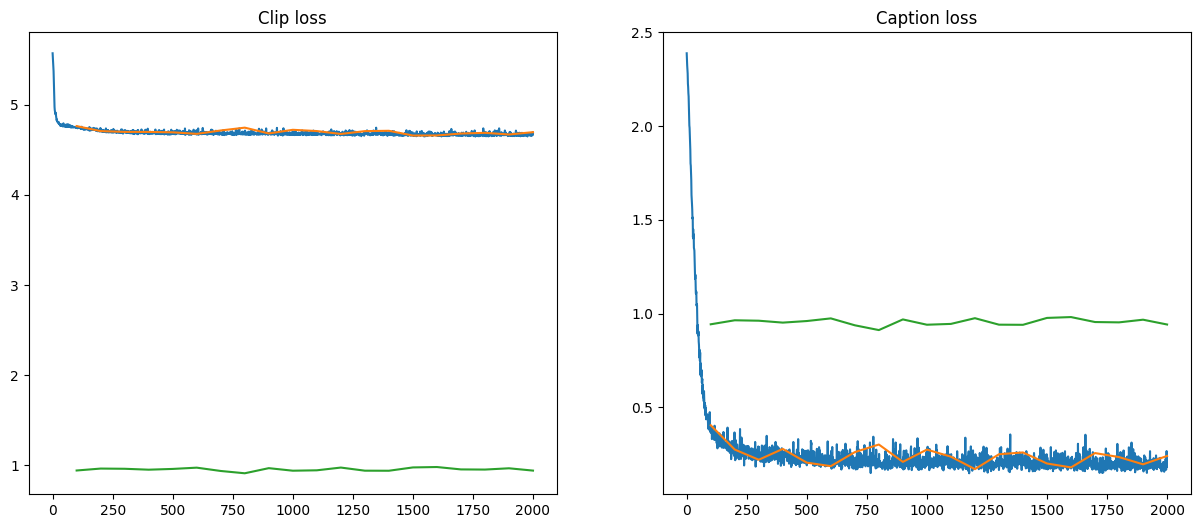

In [81]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    16, 17, 4, 0.007, do_embed=False)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=256,
    eval_data=test_data, temp=1.0, n_iters=2000, eval_evry=100)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

## When observation encoder learns captioning

With embeddings

100%|███████████████████████████████████████| 2000/2000 [02:14<00:00, 14.84it/s]


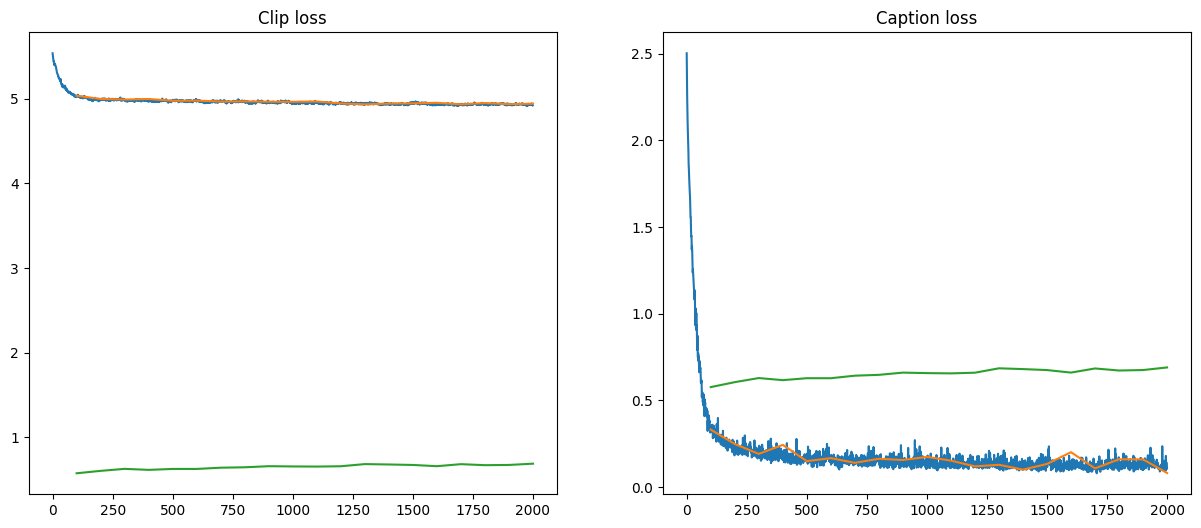

In [83]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    16, 17, 4, 0.007)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=256,
    eval_data=test_data, temp=1.0, n_iters=2000, eval_evry=100, obs_learn_capt=True)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

In [1]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    16, 17, 4, 0.007)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=256,
    eval_data=test_data, temp=1.0, n_iters=2000, eval_evry=100, obs_learn_capt=True)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

NameError: name 'init_training_objects' is not defined

100%|█████████████████████████████████████| 20000/20000 [27:33<00:00, 12.10it/s]


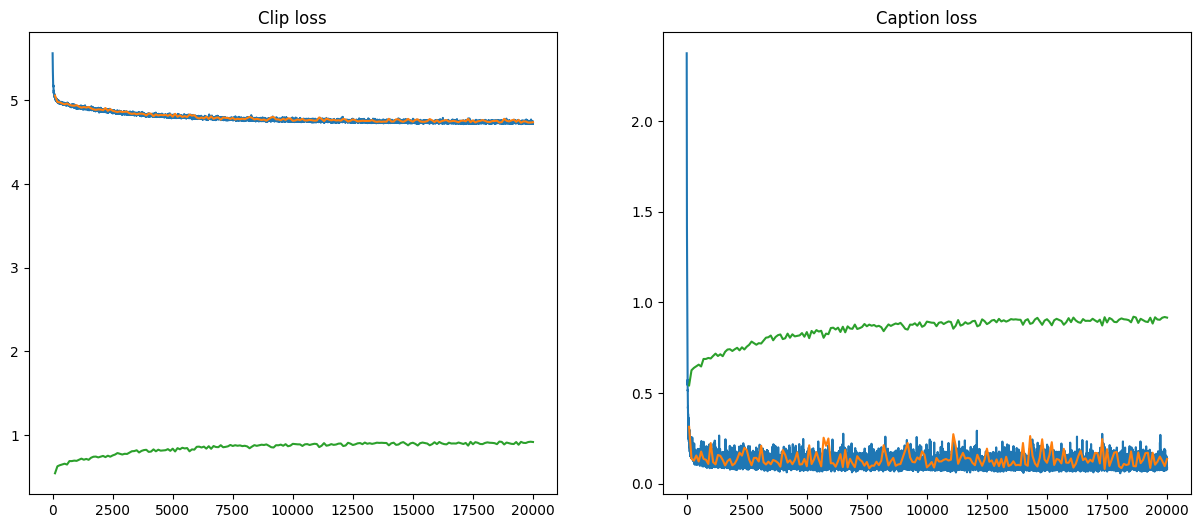

In [123]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    32, 17, 10, 0.007)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=256,
    eval_data=test_data, temp=1.0, n_iters=20000, eval_evry=100, obs_learn_capt=True)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

100%|█████████████████████████████████████| 20000/20000 [25:49<00:00, 12.91it/s]


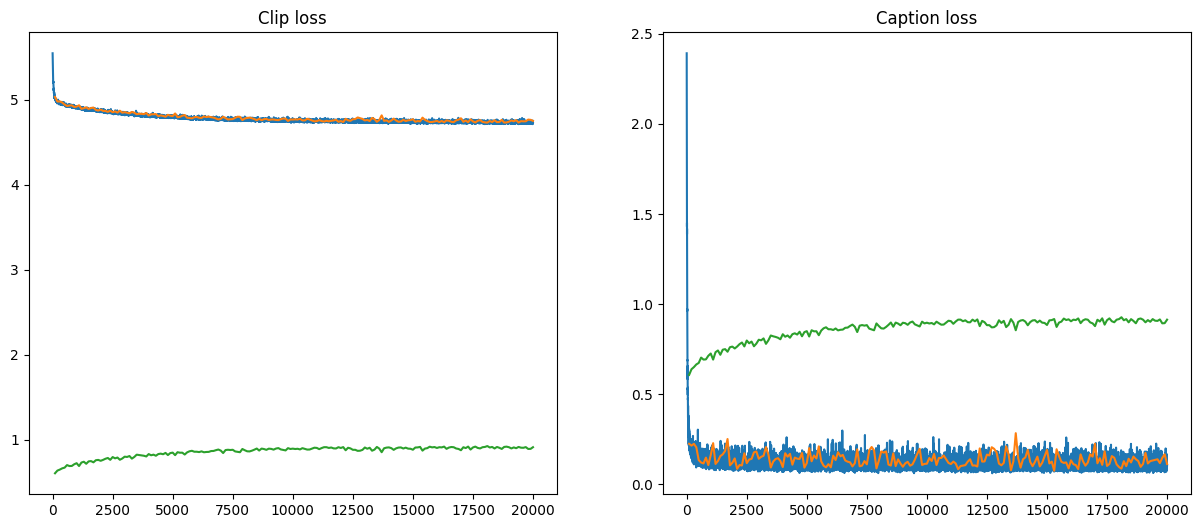

In [132]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    32, 17, 4, 0.007)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=256,
    eval_data=test_data, temp=1.0, n_iters=20000, eval_evry=100, obs_learn_capt=True)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

No embeddings

100%|█████████████████████████████████████| 20000/20000 [18:52<00:00, 17.66it/s]


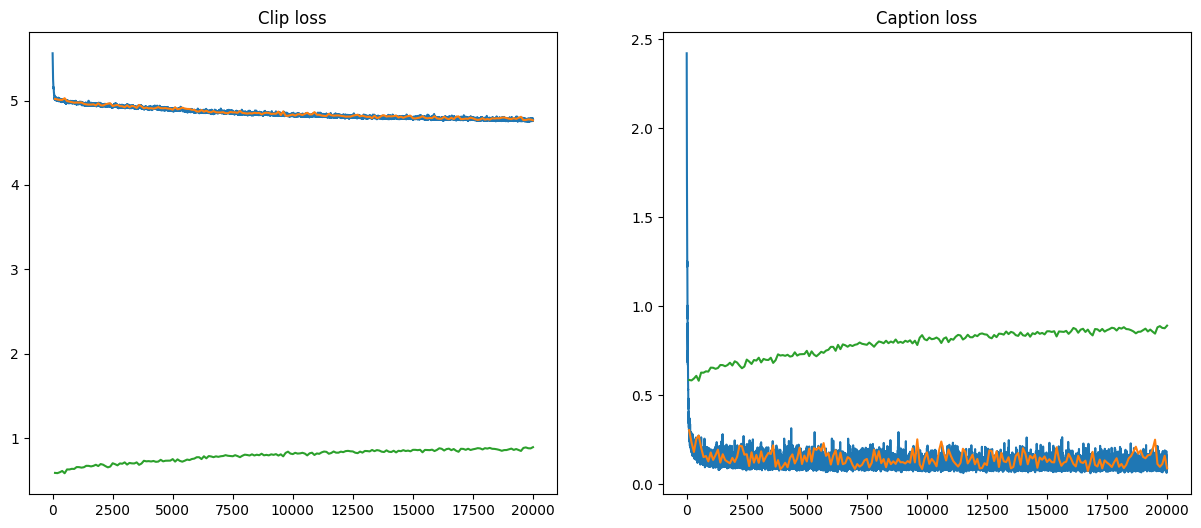

In [130]:
word_encoder, lang_enc, obs_enc, dec, cross_ent_l, nll_l, opt = init_training_objects(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'],
    16, 17, 4, 0.007, do_embed=False)

clip_train_l, clip_eval_l, dec_train_l, dec_eval_l, eval_sim = train(
    train_data, obs_enc, lang_enc, dec, word_encoder, cross_ent_l, nll_l, opt, batch_size=256,
    eval_data=test_data, temp=1.0, n_iters=20000, eval_evry=100, obs_learn_capt=True)

plot_curves([[clip_train_l, clip_eval_l, eval_sim], [dec_train_l, dec_eval_l, eval_sim]], 
            ["Clip loss", "Caption loss"])

## Visualising learnt embeddings

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 11 / 11
[t-SNE] Mean sigma: 2.765332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.616044
[t-SNE] KL divergence after 1000 iterations: 0.319937


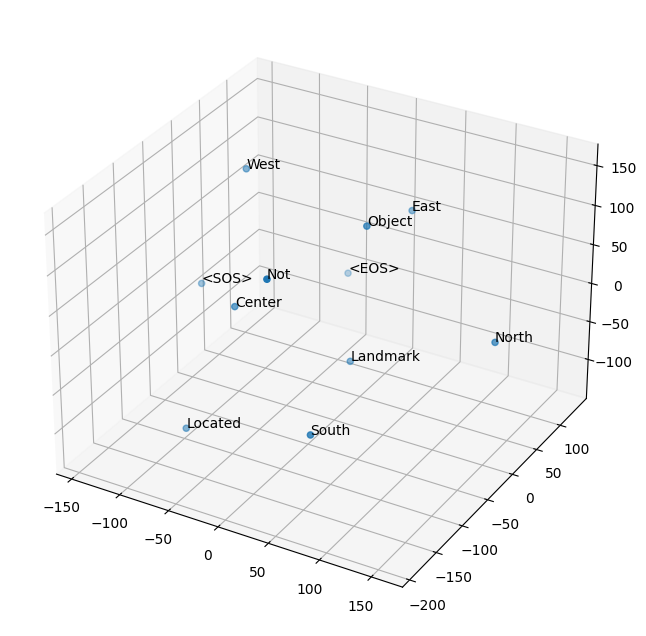

In [129]:
from sklearn.manifold import TSNE
from matplotlib import cm

tsne = TSNE(3, verbose=1, perplexity=9.0, method="exact")
tsne_proj = tsne.fit_transform(lang_enc.embed_layer.weight.data)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

ax.scatter(tsne_proj[:, 0], tsne_proj[:, 1], tsne_proj[:, 2])

voc = ["<SOS>", "<EOS>", 'South','Not','Located','West','Object','Landmark','North','Center','East']

for i, txt in enumerate(voc):
    ax.text(tsne_proj[:, 0][i], tsne_proj[:, 1][i], tsne_proj[:, 2][i], txt)